# Проект предсказывания зарплаты

Выполнил: **Пляскин Павел**

In [80]:
import pandas as pd
import numpy as np
import re
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import nltk
from nltk import WordNetLemmatizer
from nltk import tokenize
import sklearn
from sklearn.feature_extraction.text import CountVectorizer

**Описание полей**:

**LocationRaw** - The freetext location as provided by the job advertiser.

**LocationNormalized** - Adzuna's normalised location from within our own location tree, interpreted by us based on the raw location. Our normaliser is not perfect!

**ContractType** - full_time or part_time, interpreted by Adzuna from description or a specific additional field we received from the advertiser.

**ContractTime** - permanent or contract, interpreted by Adzuna from description or a specific additional field we received from the advertiser.

**Company** - the name of the employer as supplied to us by the job advertiser.

**Category** - which of 30 standard job categories this ad fits into, inferred in a very messy way based on the source the ad came from.
We know there is a lot of noise and error in this field.

**SalaryRaw** - the freetext salary field we received in the job advert from the advertiser.

**SalaryNormalised** *(целевой признак)* - the annualised salary interpreted by Adzuna from the raw salary. Note that this is always a single value based on the midpoint of any range found in the raw salary. This is the value we are trying to predict.

**SourceName** - the name of the website or advertiser from whom we received the job advert.

In [81]:
df = pd.read_csv("descriptions.csv", sep = ",")

In [82]:
df.shape

(9999, 12)

**1)** Посмотрим на нашу таблицу и убедимся в корректности считывания данных:

In [83]:
df.head()

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk
2,12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk
3,12613049,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 30000/annum 25K-30K negotiable,27500,cv-library.co.uk
4,12613647,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk


**2)** Удалим объекты в которых отсутствует какой-либо признак:

In [84]:
df = df.dropna()
df = df.reset_index(drop=True) #переназначим индексы для удобства

In [85]:
df.shape

(1821, 12)

**3)** Поле **Id** не представляет никакой практической пользы ни для анализа данных, ни для машинного обучения, по этому избавимся и от него:

In [86]:
df = df[df.columns[1:]]

In [87]:
df.head()

,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,Financial Accountant,A leading Insurance/Reinsurance Business is cu...,London,London,full_time,permanent,CMC Consulting Limited,Accounting & Finance Jobs,"40,000 - 50,000 + Bonus + B",45000,myjobs.cimaglobal.com
1,Commercial Finance Analyst,"Our client, has an unrivalled opportunity for ...",Bedfordshire,Bedfordshire,full_time,permanent,CMC Consulting Limited,Accounting & Finance Jobs,"25,000 - 35,000",30000,myjobs.cimaglobal.com
2,Financial Accountant,"Our client, a leading Insurance company, is cu...",London,London,full_time,permanent,CMC Consulting Limited,Accounting & Finance Jobs,"40,000 - 45,000 + Bonus + B",42500,myjobs.cimaglobal.com
3,Commercial Analyst,"My client, a market leading software company, ...",Berkshire,Berkshire,full_time,permanent,CMC Consulting Limited,Accounting & Finance Jobs,"50,000 - 55,000 + Benefits",52500,myjobs.cimaglobal.com
4,Teachers,iday s unrivalled originality has captured the...,Norfolk,Norfolk,part_time,contract,Engage Education,Teaching Jobs,100 - 145/day,29400,cv-library.co.uk


**4)** Выполним некоторое преобразование поля **FullDescription** и **Title**, а именно удалим оттуда все знаки препинания

In [88]:
df["FullDescription"] = [re.sub('[^0-9a-zA-Z ]', '', descr) for descr in df['FullDescription']]
df["Title"] = [re.sub('[^0-9a-zA-Z ]', '', title) for title in df['Title']]

**5)** Заметим, что признаки **ContractType** и **ContractTime** имеют бинарный тип, поэтому следует заменить их на числовые значения

In [89]:
print ("ContractType:",df.ContractType.unique())
print ("ContractTime:",df.ContractTime.unique())

ContractType: ['full_time' 'part_time']
ContractTime: ['permanent' 'contract']


**5.1)** В **ContractType** заменим **full_time** на **1**, а **part_time** на **0**:

In [90]:
x = {'full_time' : 1, 'part_time' : 0}
df["ContractType"] = df["ContractType"].map(x)

**5.2)** В **ContractTime** заменим **permanent** на **1** и **contract** на **0**:

In [91]:
x = {'permanent' : 1, 'contract' : 0}
df["ContractTime"] = df["ContractTime"].map(x)

In [92]:
df.head()

,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,Financial Accountant,A leading InsuranceReinsurance Business is cur...,London,London,1,1,CMC Consulting Limited,Accounting & Finance Jobs,"40,000 - 50,000 + Bonus + B",45000,myjobs.cimaglobal.com
1,Commercial Finance Analyst,Our client has an unrivalled opportunity for a...,Bedfordshire,Bedfordshire,1,1,CMC Consulting Limited,Accounting & Finance Jobs,"25,000 - 35,000",30000,myjobs.cimaglobal.com
2,Financial Accountant,Our client a leading Insurance company is curr...,London,London,1,1,CMC Consulting Limited,Accounting & Finance Jobs,"40,000 - 45,000 + Bonus + B",42500,myjobs.cimaglobal.com
3,Commercial Analyst,My client a market leading software company is...,Berkshire,Berkshire,1,1,CMC Consulting Limited,Accounting & Finance Jobs,"50,000 - 55,000 + Benefits",52500,myjobs.cimaglobal.com
4,Teachers,iday s unrivalled originality has captured the...,Norfolk,Norfolk,0,0,Engage Education,Teaching Jobs,100 - 145/day,29400,cv-library.co.uk


**6)** Сделаем некоторую визуалицию наших данных

Построим графики отражающие зависимость **SalaryNormalized** от **ContractType** и **ContractTime**

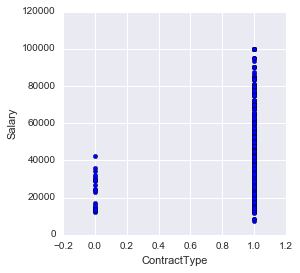

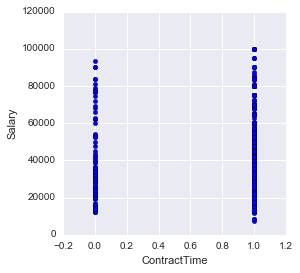

In [35]:
plt.figure(figsize=(4, 4))
plt.scatter(df["ContractType"], df["SalaryNormalized"])
plt.xlabel("ContractType")
plt.ylabel("Salary")

plt.figure(figsize=(4, 4))
plt.scatter(df["ContractTime"], df["SalaryNormalized"])
plt.xlabel("ContractTime")
plt.ylabel("Salary")

Из этих двух графиков видно, что вакансии на **part_time** имеют намного более низкую максимальную зарплату по сравнению с **full_time**. Особой разницы между **permanent** и **contract** вакансиями нет

Построим гистограму по целевому признаку:

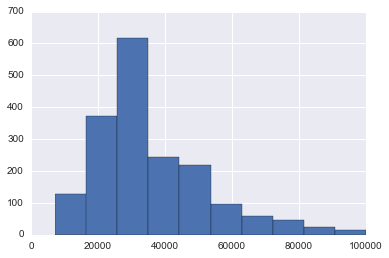

In [36]:
df["SalaryNormalized"].hist();

Из этого графика видно, что наиболее часто предлагается зарплата от **30000** до **40000**

Узнаем некоторое описание числовых признаков

In [37]:
df.describe()

,ContractType,ContractTime,SalaryNormalized
count,1821.000000,1821.000000,1821.000000
mean,0.985722,0.913784,35954.645799
std,0.118667,0.280760,16408.913836
min,0.000000,0.000000,7200.000000
25%,1.000000,1.000000,25000.000000
50%,1.000000,1.000000,32000.000000
75%,1.000000,1.000000,44650.000000
max,1.000000,1.000000,100000.000000


Построим график зависимости **SalaryNormalized** от **Category**

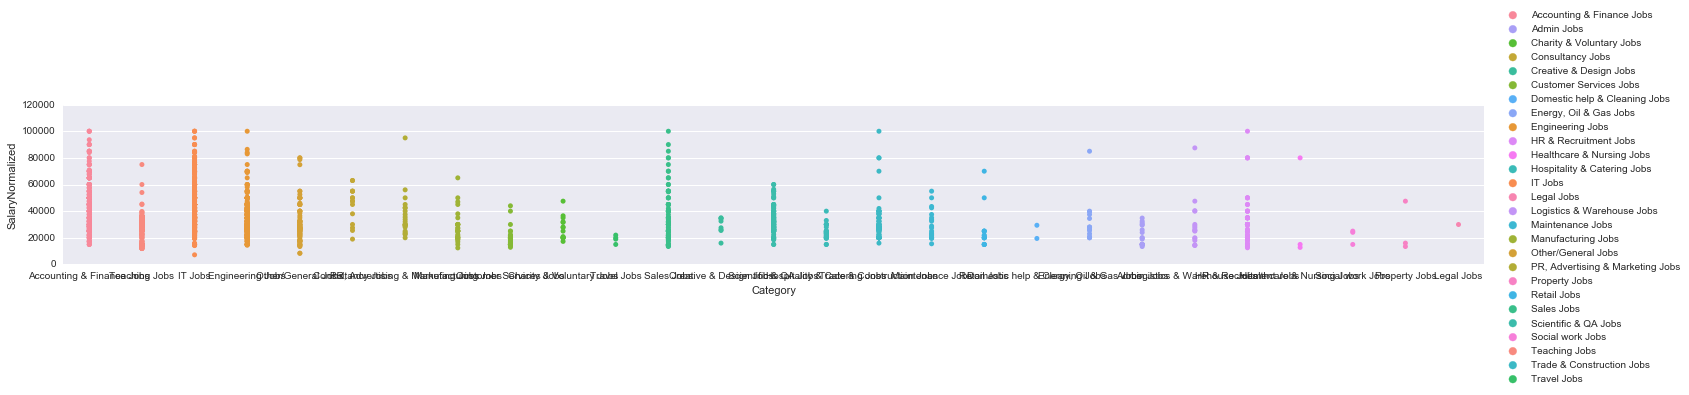

In [38]:
sns.factorplot(x="Category", y="SalaryNormalized", kind='strip',  data=df, size=3, aspect=7, hue='Category').add_legend()

**7)** Выполним лемматизацию для признака **FullDescription**

In [93]:
wnl = nltk.WordNetLemmatizer()

In [94]:
df["FullDescription"] = [tokenize.word_tokenize(descr) for descr in df["FullDescription"]]
df["FullDescription"] = [[wnl.lemmatize(word) for word in descr] for descr in df["FullDescription"]]

In [95]:
df["FullDescription"] = [" ".join(descr) for descr in df["FullDescription"]]

**8)** Создадим матрицу объект-признак из всех описаний вакансий:

In [39]:
vectorizer = CountVectorizer()
words = vectorizer.fit_transform(df["FullDescription"]).toarray()

**9)** Склеим ее с нашими данными

преобразуем полученную матрицу в датафрейм и поставим названия колонок соотствующие признаку, то есть слову

In [40]:
words = pd.DataFrame(words)
words.columns = vectorizer.get_feature_names()

Сделаем новый датафрейм, который будет представлять из себя матрицу объекты-признаки

In [41]:
data = pd.concat([df, words], axis=1)
data = data.drop("FullDescription", axis=1) #удалим уже ненужный нам столбец с описанием

In [42]:
data.head()

,Title,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,...,youyou,yr,yr1,yrs,ys,zealous,zend,zero,zone,zuken
0,Financial Accountant,London,London,1,1,CMC Consulting Limited,Accounting & Finance Jobs,"40,000 - 50,000 + Bonus + B",45000,myjobs.cimaglobal.com,...,0,0,0,0,0,0,0,0,0,0
1,Commercial Finance Analyst,Bedfordshire,Bedfordshire,1,1,CMC Consulting Limited,Accounting & Finance Jobs,"25,000 - 35,000",30000,myjobs.cimaglobal.com,...,0,0,0,0,0,0,0,0,0,0
2,Financial Accountant,London,London,1,1,CMC Consulting Limited,Accounting & Finance Jobs,"40,000 - 45,000 + Bonus + B",42500,myjobs.cimaglobal.com,...,0,0,0,0,0,0,0,0,0,0
3,Commercial Analyst,Berkshire,Berkshire,1,1,CMC Consulting Limited,Accounting & Finance Jobs,"50,000 - 55,000 + Benefits",52500,myjobs.cimaglobal.com,...,0,0,0,0,0,0,0,0,0,0
4,Teachers,Norfolk,Norfolk,0,0,Engage Education,Teaching Jobs,100 - 145/day,29400,cv-library.co.uk,...,0,0,0,0,0,0,0,0,0,0


**10)** Сохраним матрицу в csv

In [43]:
data.to_csv('data.csv')

#  Задание второго модуля

**1)** Выделим обучающую выборку и вектор ответов

Удалим из выборки признаки:

1. *LocationRaw*,  так как он дублируется в признаке *LocationNormalized*

2. *SalaryRaw* и *SalaryNormalized*, так как это наш целевой признак

In [44]:
X = data.drop(['LocationRaw', 'SalaryRaw', 'SalaryNormalized'], 1)
Y = data['SalaryNormalized']

In [45]:
X['ContractType'] = X['ContractType'].astype(str)
X['ContractTime'] = X['ContractTime'].astype(str)

In [46]:
from sklearn.feature_extraction import DictVectorizer

In [47]:
categories = ['Title', 'LocationNormalized', 'ContractType', 'ContractTime', 'Company', 'Category', 'SourceName']
dict_vectorizer = DictVectorizer()
features = X[categories].T.to_dict().values()
X_category = dict_vectorizer.fit_transform(features).toarray()

In [48]:
X_category = pd.DataFrame(X_category, columns=dict_vectorizer.get_feature_names())

In [49]:
others = list(set(X.columns.values.tolist()) - set(categories))

In [50]:
X_coded_cat =  pd.concat([X_category, X[others]],  axis=1, join='inner')

In [51]:
X_coded_cat.head()

,Category=Accounting & Finance Jobs,Category=Admin Jobs,Category=Charity & Voluntary Jobs,Category=Consultancy Jobs,Category=Creative & Design Jobs,Category=Customer Services Jobs,Category=Domestic help & Cleaning Jobs,"Category=Energy, Oil & Gas Jobs",Category=Engineering Jobs,Category=HR & Recruitment Jobs,...,winforms,ad,planned,steadilythis,phases,crbpolice,developer,flourishing,importancesubstantial,brbrthis
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


## Разделение выборки на обучение и тест

In [52]:
X_train = X_coded_cat[:1500]
X_test = X_coded_cat[1500:]
Y_train = Y[:1500]
Y_test = Y[1500:]

## Сравним различные изученые методы

В качетсве основной метрики была выбрана  **Mean absolute error** (MAE), как дополнительная метрика будет рассматриваться **r2**

### Линейная регрессия

In [32]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [33]:
from sklearn.linear_model import LinearRegression

In [34]:
Lin_reg = LinearRegression()
Lin_reg.fit(X_train, Y_train)
lin_reg_predict = Lin_reg.predict(X_test)

In [35]:
print("MAE:", mean_absolute_error(Y_test, lin_reg_predict))
print("r2 score:", r2_score(Y_test, lin_reg_predict))

MAE: 11783.0357042
r2 score: -0.0390302569278


### Ridge

In [53]:
from sklearn.linear_model import RidgeCV, LassoCV

In [54]:
lr_R = RidgeCV(alphas=np.logspace(1, 10, 100))
lr_R.fit(X_train, Y_train)

RidgeCV(alphas=array([  1.00000e+01,   1.23285e+01, ...,   8.11131e+09,   1.00000e+10]),
    cv=None, fit_intercept=True, gcv_mode=None, normalize=False,
    scoring=None, store_cv_values=False)

In [38]:
lr_R_predict = lr_R.predict(X_test)
mae_ridge = mean_absolute_error(Y_test, lr_R_predict)
r2_ridge = r2_score(Y_test, lr_R_predict)
print("MAE:", mae_ridge)
print("r2 score:", r2_ridge)

MAE: 8872.95075924
r2 score: 0.362841086621


### Lasso

In [39]:
lr_L = LassoCV(alphas=np.logspace(1, 10, 100))
lr_L.fit(X_train[:100], Y_train[:100])

C:\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


LassoCV(alphas=array([  1.00000e+01,   1.23285e+01, ...,   8.11131e+09,   1.00000e+10]),
    copy_X=True, cv=None, eps=0.001, fit_intercept=True, max_iter=1000,
    n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [40]:
lr_L_predict = lr_L.predict(X_test)
print("MAE:", mean_absolute_error(Y_test, lr_L_predict))
print("r2 score:", r2_score(Y_test, lr_L_predict))

MAE: 14729.5915373
r2 score: -0.197282725549


### DecisionTree

In [41]:
from sklearn.grid_search import GridSearchCV
from sklearn import tree

In [42]:
parameters = {"max_depth":[2, 4, 8, 16], "min_samples_leaf":[1, 10, 50], 
              "max_leaf_nodes":[10, 100, 1000]}
cv_trees = GridSearchCV(tree.DecisionTreeRegressor(), parameters)
cv_trees.fit(X_train.as_matrix(), Y_train.as_matrix());

In [43]:
cv_trees_predict = cv_trees.predict(X_test)
print("MAE:", mean_absolute_error(Y_test, cv_trees_predict))
print("r2 score:", r2_score(Y_test, cv_trees_predict))

MAE: 11083.4598435
r2 score: 0.114377242475


### kNN

In [44]:
from sklearn.neighbors import KNeighborsRegressor

In [45]:
parameters = {'n_neighbors':np.arange(25, 40, 5), 'weights':['uniform', 'distance']}
cv_knn = GridSearchCV(KNeighborsRegressor(), parameters)
cv_knn.fit(X_train.as_matrix(), Y_train.as_matrix());

In [46]:
cv_knn_predict = cv_knn.predict(X_test)
print("Best parameters:", cv_knn.best_params_)
print("MAE:", mean_absolute_error(Y_test, cv_knn_predict))
print("r2 score:", r2_score(Y_test, cv_knn_predict))

Best parameters: {'n_neighbors': 25, 'weights': 'distance'}
MAE: 10582.2805525
r2 score: 0.12005378902


## Сравнение результатов

Проведем сравнение показательй нашей основной метрики **MAE**:

С поставленной задачей лучше всего справился **Ridge** показав минимальное значение **MAE = 8872**, также им был достигнут лучший показатель по дополнительной метрике **r2 = 0.36**

Хуже всего справился **Lasso** показав значение **MAE = 14729**, **r2 = -0.19**

# 2 модуль [2/2]

## Работа с признаками

### Tf - Idf features

Попробуем вместо обычного **DictVectorizer**, который только дает информацию о вхождении какого-либо слова, применить **TfidfVectorizer** c помощью него мы сможем посчитать частоту вхождения и важность этого слова.

In [96]:
#вернемся к данным с начальной предобработкой (удалены пропуски, id объектов, преобразование текстов)
df_n = df

In [97]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [98]:
def TfIdfVec (vectorizer, column_name):
    global df_n
    features = df_n[column_name].T.to_dict().values()
    train_features = vectorizer.fit_transform(features).toarray()
    X_category = pd.DataFrame(train_features, columns=vectorizer.get_feature_names())
    df_n = pd.concat([X_category, df_n], axis=1, join='inner')

Выберем по 200 самых важных и частых слов в признаках **Title** и **FullDescription**

In [99]:
vectorizer = TfidfVectorizer(norm='l1', max_features = 200, analyzer = 'word', strip_accents='unicode', binary=True)
categories = ['Title','FullDescription']
for name in categories:
    TfIdfVec(vectorizer, name)

Кодировка категориальных признаков

In [100]:
categories = ['LocationNormalized', 'ContractType', 'ContractTime', 'Company', 'Category', 'SourceName']
dict_vectorizer = DictVectorizer()
features = df_n[categories].T.to_dict().values()
X_category = dict_vectorizer.fit_transform(features).toarray()

In [101]:
X_category = pd.DataFrame(X_category, columns=dict_vectorizer.get_feature_names())

In [102]:
others = list(set(X.columns.values.tolist()) - set(categories))

In [103]:
frame = df_n.drop(['LocationRaw', 'SalaryRaw', 'Title','FullDescription', 'LocationNormalized', 
               'ContractType', 'ContractTime', 'Company', 'Category', 'SourceName'], 1)

In [104]:
frame =  pd.concat([X_category, frame],  axis=1, join='inner')

In [105]:
frame.shape

(1821, 901)

Сформируем новую обучающаю выборку

In [106]:
X = frame.drop('SalaryNormalized', axis=1)
Y = frame['SalaryNormalized']

In [107]:
from sklearn.cross_validation import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

### Посмотрим результаты на новой выборке

Будем использовать **Ridge** так как он лучше всех показал себя в прошлых сравнениях

In [67]:
lr_R_n = RidgeCV(alphas=np.logspace(1, 10, 100), scoring='mean_absolute_error')
lr_R_n.fit(X_train, Y_train);

In [206]:
lr_R_n_predict = lr_R_n.predict(X_test)
mae_ridge_tf = mean_absolute_error(Y_test, lr_R_n_predict)
r2_ridge_tf = r2_score(Y_test, lr_R_n_predict)
print("С TF - IDF признаками:")
print("\tMAE:", mae_ridge_tf)
print("\tr2 score:", r2_ridge_tf)
print("")
print("На старых данных: ")
print("\tMAE:", mae_ridge)
print("\tr2 score:", r2_ridge)

С TF - IDF признаками:
	MAE: 9116.55667758
	r2 score: 0.384661271088

На старых данных: 
	MAE: 8872.95075924
	r2 score: 0.362841086621


Мы видим, что результаты улучшились улучшились

## PCA

Применим метод главных компонент

In [68]:
from sklearn.decomposition import PCA

pca = PCA(n_components=680)
X_transform = pca.fit_transform(X)

In [69]:
X_train_pca, X_test_pca, Y_train, Y_test = train_test_split(X_transform, Y, test_size=0.3, random_state=42)

In [70]:
ridge_pca = RidgeCV(alphas=np.logspace(1, 10, 100), scoring='mean_absolute_error')
ridge_pca.fit(X_train_pca, Y_train);

In [210]:
ridge_pca_pred = ridge_pca.predict(X_test_pca)
mae_ridge_pca = mean_absolute_error(Y_test, ridge_pca_pred)
r2_ridge_pca = r2_score(Y_test, ridge_pca_pred)

In [211]:
print("Качество после применения PCA:")
print("\tMAE:",mae_ridge_pca)
print("\tr2 score:",r2_ridge_pca)
print("")
print("Качество до применения PCA:")
print("\tMAE:", mae_ridge_tf)
print("\tr2 score:", r2_ridge_tf)

Качество после применения PCA:
	MAE: 9115.84673602
	r2 score: 0.384719747405

Качество до применения PCA:
	MAE: 9116.55667758
	r2 score: 0.384661271088


Улучшение результатов сново произошло, однако незначительное. Но так как мы удалили аж 220 признаков, дальнейщая работа с данными будет происходить быстрее, следовательно использование **PCA** более чем обоснованно.

## Работа с объектами

### Удаление редких объектов

In [108]:
counted_values = frame['SalaryNormalized'].value_counts()

In [109]:
#удалим объекты встречающиеся меньше 20 раз
selected_values = dict(counted_values.where(counted_values < 20).dropna())
frame_s = frame[~frame.SalaryNormalized.isin(selected_values)];

In [110]:
frame_s.shape

(1055, 901)

In [111]:
X = frame_s.drop('SalaryNormalized', axis=1)
Y = frame_s['SalaryNormalized']

In [112]:
pca = PCA(n_components=680)
X_transform_s = pca.fit_transform(X)

In [113]:
X_train_short, X_test_short, Y_train_short, Y_test_short = train_test_split(X_transform_s, Y, test_size=0.3, random_state=42)

In [114]:
ridge_short = RidgeCV(alphas=np.logspace(1, 10, 100), scoring='mean_absolute_error')
ridge_short.fit(X_train_short, Y_train_short);

In [379]:
ridge_short_pred = ridge_short.predict(X_test_short)
mae_ridge_short = mean_absolute_error(Y_test_short, ridge_short_pred)
r2_ridge_short = r2_score(Y_test_short, ridge_short_pred)

In [380]:
print("Качество после удаления редких объектов")
print("\tMAE:",mae_ridge_short)
print("\tr2 score:",r2_ridge_short)
print("Качество без удаления:")
print("\tMAE:",mae_ridge_pca)
print("\tr2 score:",r2_ridge_pca)

Качество после удаления редких объектов
	MAE: 7548.0443487
	r2 score: 0.401695206582
Качество без удаления:
	MAE: 9115.84673602
	r2 score: 0.384719747405


После удаления редких объектов качество сильно выросло, скорее всего это связано с переобучением, так как модель настраивалась на "шумы"

# Предсказание тестовой выборки

In [165]:
test = pd.read_csv('test.csv', sep = ",")

In [166]:
Id = test.Id

In [167]:
test = test[test.columns[2:]]

In [168]:
test = test.fillna('nan')

In [169]:
test["FullDescription"] = [re.sub('[^0-9a-zA-Z ]', '', descr) for descr in test['FullDescription']]
test["Title"] = [re.sub('[^0-9a-zA-Z ]', '', title) for title in test['Title']]

In [170]:
def TfIdfVec (vectorizer, column_name):
    global test
    features = test[column_name].T.to_dict().values()
    train_features = vectorizer.transform(features).toarray()
    X_category = pd.DataFrame(train_features, columns=vectorizer.get_feature_names())
    test = pd.concat([X_category, test], axis=1, join='inner')

In [171]:
categories = ['Title','FullDescription']
for name in categories:
    TfIdfVec(vectorizer, name)

In [172]:
categories = ['LocationNormalized', 'ContractType', 'ContractTime', 'Company', 'Category', 'SourceName']

features = test[categories].T.to_dict().values()
X_category = dict_vectorizer.transform(features).toarray()

In [173]:
X_category = pd.DataFrame(X_category, columns=dict_vectorizer.get_feature_names())
others = list(set(test.columns.values.tolist()) - set(categories))
test = test.drop(['LocationRaw', 'Title','FullDescription', 'LocationNormalized', 
               'ContractType', 'ContractTime', 'Company', 'Category', 'SourceName'], 1)

In [174]:
test =  pd.concat([X_category, test],  axis=1, join='inner')

In [175]:
test = pca.transform(test)

In [176]:
test_predict = ridge_short.predict(test)

In [177]:
testcsv = pd.DataFrame(test_predict, columns=['Prediction'])

In [178]:
testcsv = pd.concat([Id, testcsv], axis=1, join='inner')

In [181]:
testcsv.to_csv('prediction_values.csv', index=False)